In [1]:
#import namespaces and matplotlib

import pandas as pd 
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import math 

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
bc_data = pd.read_csv("breast_cancer.csv")

In [3]:
#review bc_data
bc_data.head()

,Unnamed: 0,id number,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,0,1000025,5,1,1,1,2,1,3,1,1,0
1,1,1002945,5,4,4,5,7,10,3,2,1,0
2,2,1015425,3,1,1,1,2,2,3,1,1,0
3,3,1016277,6,8,8,1,3,4,3,7,1,0
4,4,1017023,4,1,1,3,2,1,3,1,1,0


In [5]:
#The unnamed attribute and id numbers can be dropped since they do not contain information that helps with the analysis 
bc_data = bc_data.drop(['Unnamed: 0', 'id number'], axis=1)

In [6]:
#Malignant is the dependent variable we want to predict, so we pop it and make it the y variable 
y = bc_data.pop("malignant")

In [8]:
#Set up the test train split with random state = 42 to enable reproducing the results
X_train, X_test, y_train, y_test = train_test_split(bc_data, y, test_size=.2,random_state=42)

In [10]:
#Optimizing the hyperparameters for the model with Exhaustive Grid Search 

#Define hyperparameters to optimize
n_estimators = [250,450,550]
max_features = ['auto','sqrt','log2']
min_samples_split = [3,5,7]

#set the number of llel jobs for the rfc 
rfc = RandomForestClassifier(n_jobs=1)

estimator = GridSearchCV(rfc,
                         dict(n_estimators=n_estimators,
                              max_features=max_features,
                              min_samples_split=min_samples_split
                              ), cv=None, n_jobs=-1)

In [11]:
#fit the estimator to the training sets 
estimator.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [3, 5, 7], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [250, 450, 550]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [12]:
#view the best estimator
estimator.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=550, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
#set the best random forest classifier to equal that with the optimized hyper parameters
best_rfc = estimator.best_estimator_

In [15]:
#To determine the accuracy of the RFC 
accuracy = accuracy_score(y_test, best_rfc.predict(X_test))
print "The Accuracy of the RFC is: ", accuracy

The Accuracy of the RFC is:  0.971428571429


In [16]:
#Output the classification report to view the precision and recall values for the generated RFC 
print classification_report(y_test, best_rfc.predict(X_test))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98        95
          1       0.96      0.96      0.96        45

avg / total       0.97      0.97      0.97       140



In [17]:
#To obtain the AUC score 
roc = roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:,1])
print "The AUC Score for this RFC is: ", roc

The AUC Score for this RFC is:  0.99649122807


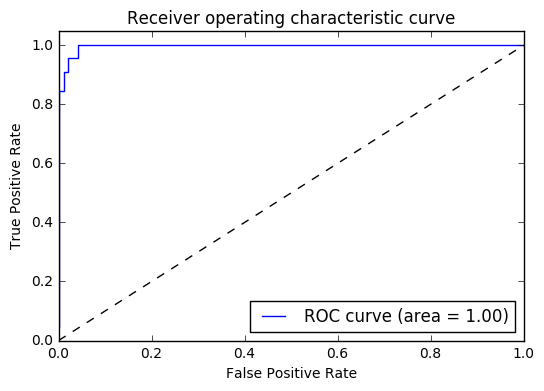

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, best_rfc.predict_proba(X_test)[:,1])
# ROC curve for observed malignant 
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

# K-Fold Cross Validation

In [20]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(best_rfc, bc_data, y, cv=10)

In [21]:
scores

array([ 0.91549296,  0.97142857,  0.97142857,  0.91428571,  0.98571429,
        0.98571429,  0.97142857,  0.98571429,  0.98550725,  1.        ])

In [28]:
mean_score = scores.mean()
std_dev = scores.std()
std_error = scores.std() / math.sqrt(scores.shape[0])
ci = 2.262 * std_error #where 2.262 is the area under 95% of a 2-tailed test
lower_b = mean_score - ci 
upper_b = mean_score + ci 

print "- The Score is %f +/- %f" % (mean_score, ci)
print '- There is a 95 percent probability that repeating this diagnosis would give an average AUC score between %f and %f' % (lower_b, upper_b) 

- The Score is 0.968671 +/- 0.020162
- There is a 95 percent probability that repeating this diagnosis would give an average score between 0.948509 and 0.988834


# Description of Model Performance

The values for the performance of the random forest model that was derived are: 
  AUC = 0.99649122807
  Accuracy = 0.971428571429
  Precision = 0.96
  and Recall = 0.96
  
While the  average AUC score for the K-Fold cross validation (10-fold cross-validation) was 0.968671 +/- 0.020162.

A comparison of both models shows that the model generated using the Random Forest Classifier is more accurate as it yields as its AUC scores is greater than that of the model from the K-fold cross validation model. With a value of approximately 1 it means that there are close to 0 false positive diagnosis of breast cancer and that close to 100% of cancer incidences area accurately diagnosed. 